In [50]:
# EJECUTA ESTA CELDA PRIMERO - Configurar rutas correctamente
import sys
import os

# Asegurar que estamos en el directorio correcto
os.chdir(r'C:\Users\sjaim\Metahuristica')
sys.path.insert(0, r'C:\Users\sjaim\Metahuristica')

print("✓ Rutas configuradas")
print(f"  Working dir: {os.getcwd()}")
print(f"  sys.path[0]: {sys.path[0]}")

✓ Rutas configuradas
  Working dir: C:\Users\sjaim\Metahuristica
  sys.path[0]: C:\Users\sjaim\Metahuristica


---

## Paso 1: Importar Librerías y Configurar el Entorno

In [51]:
# Importar lo que necesitamos
import sys
sys.path.insert(0, '/root/Metahuristica')  # Ajusta la ruta si es necesario

from src.data_loader import parse_ampl_dat, build_instance
from src.encoding import encode_routes, decode_vector, route_based_crossover, swap_mutation, insert_mutation
from src.simulator import evaluate_individual, schedule_muelles
from src.ga_utils import local_search_on_routes, population_diversity

import pandas as pd
import numpy as np
import json
from copy import deepcopy
import random

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


---

## Paso 2: Cargar los Datos del Archivo .dat

El archivo `.dat` contiene todos los parámetros del problema:
- Clientes (dónde entregar)
- Camiones (vehículos disponibles)
- Costos y capacidades
- Ventanas de tiempo
- Y mucho más...

**Cambiar la ruta del archivo si necesitas cargar otro:**

In [52]:
# 📁 CAMBIAR ESTA RUTA SI TIENES OTRO ARCHIVO
dat_file = 'instances/sebas_4camiones_14clientes.dat'

# Cargar y construir la instancia
parsed = parse_ampl_dat(dat_file)
inst = build_instance(parsed)

print(f"✓ Instancia cargada desde: {dat_file}")
print(f"  - Nodos (depósito + clientes): {inst.n_nodes()}")
print(f"  - Camiones disponibles: {len(inst.trucks)}")

✓ Instancia cargada desde: instances/sebas_4camiones_14clientes.dat
  - Nodos (depósito + clientes): 15
  - Camiones disponibles: 4


---

## Paso 3: Entender los Parámetros del Problema

### 3.1 Parámetros Principales

In [53]:
print("="*60)
print("PARÁMETROS DEL PROBLEMA")
print("="*60)

# Información de camiones
print("\n CAMIONES:")
truck_data = []
for tid, truck in inst.trucks.items():
    truck_data.append({
        'ID': tid,
        'Capacidad': truck.Cap,
        'Costo/Hora': truck.CH,
        'Costo 6h': truck.CF6,
        'Costo 12h': truck.CF12,
        'Por Hora': truck.esHora
    })
df_trucks = pd.DataFrame(truck_data)
print(df_trucks.to_string(index=False))

# Parámetros globales
print("\n PARÁMETROS TEMPORALES:")
time_params = {
    'Hora máxima de regreso': inst.params.get('tlim', 18.0),
    'Hora de almuerzo': inst.params.get('alm', 14.0),
    'Duración almuerzo': inst.params.get('talm', 1.0),
    'Duración máxima ruta': 12.0
}
for k, v in time_params.items():
    print(f"  {k}: {v}")

# Penalizaciones
print("\n PENALIZACIONES:")
penalties = {
    'Llegar antes en cliente crítico': inst.params.get('pcmin_c', 10),
    'Llegar después en cliente crítico': inst.params.get('pcmax_c', 15),
    'Llegar antes en cliente no crítico': inst.params.get('pcmin_nc', 5),
    'Llegar después en cliente no crítico': inst.params.get('pcmax_nc', 8),
    'Regresar después de 18:00': inst.params.get('preg', 20),
    'Por hora de espera': inst.params.get('pw', 10000)
}
for k, v in penalties.items():
    print(f"  {k}: {v}")

# Muelles
print("\n MUELLES:")
print(f"  Máximo camiones simultáneos: {inst.params.get('nmuelles', 2)}")
print(f"  Tiempo de carga: {inst.params.get('tcarga', 0.5)} horas")

PARÁMETROS DEL PROBLEMA

 CAMIONES:
 ID  Capacidad  Costo/Hora  Costo 6h  Costo 12h  Por Hora
  1       80.0       123.0     277.0      429.0         1
  2      133.0       116.0     411.0      478.0         0
  3      121.0       154.0     420.0      382.0         1
  4      116.0       114.0     303.0      558.0         0

 PARÁMETROS TEMPORALES:
  Hora máxima de regreso: 18.0
  Hora de almuerzo: 14.0
  Duración almuerzo: 1.0
  Duración máxima ruta: 12.0

 PENALIZACIONES:
  Llegar antes en cliente crítico: 10
  Llegar después en cliente crítico: 15
  Llegar antes en cliente no crítico: 5
  Llegar después en cliente no crítico: 8
  Regresar después de 18:00: 20
  Por hora de espera: 10000

 MUELLES:
  Máximo camiones simultáneos: 2
  Tiempo de carga: 0.5 horas


### 3.2 Información de Clientes

In [26]:
print("\n CLIENTES:")
print(f"  Total de clientes: {sum(1 for c in inst.clients.values() if c.escliente == 1)}")
print("\nDetalle de cada cliente:")

client_data = []
for cid, client in inst.clients.items():
    if client.escliente == 1:  # Solo mostrar clientes, no depósito
        client_data.append({
            'Cliente': cid,
            'Entrega': client.DemE,
            'Recogida': client.DemR,
            'Tiempo Servicio': round(client.TS, 2),
            'Min Llegada': client.MinDC,
            'Max Llegada': client.MaxDC,
            'Crítico': '✓' if client.escritico == 1 else ''
        })

df_clients = pd.DataFrame(client_data)
print(df_clients.to_string(index=False))


 CLIENTES:
  Total de clientes: 14

Detalle de cada cliente:
 Cliente  Entrega  Recogida  Tiempo Servicio  Min Llegada  Max Llegada Crítico
       1     18.0       4.0             0.34          8.0         16.0       ✓
       2     23.0       3.0             0.29          6.0          9.0       ✓
       3      6.0       1.0             0.23         11.0         13.0       ✓
       4     16.0       0.0             0.32         12.0         19.0       ✓
       5     24.0       3.0             0.33          9.0         14.0       ✓
       6      9.0       2.0             0.18          6.0         13.0        
       7     23.0       1.0             0.35         11.0         16.0        
       8     21.0       5.0             0.35         12.0         17.0        
       9      7.0       4.0             0.13          9.0         14.0        
      10     22.0       3.0             0.31          9.0         13.0       ✓
      11     22.0       0.0             0.11         10.0         17.

---

## Paso 4: Entender la Codificación (Cómo Representamos las Rutas)

### ¿Cómo se codifica una solución?

Una solución GA es un **vector** que contiene la secuencia de todos los clientes divididos entre camiones.

**Formato:** `[0, cliente1, cliente2, ..., 0, cliente3, cliente4, ..., 0, ...]`

- `0` = Depósito (donde comienza y termina cada ruta)
- Los números entre `0`s son clientes que visita ese camión

In [28]:
# Ejemplo de un vector solución
print("EJEMPLO DE CODIFICACIÓN:")
print("="*60)

# Vector de ejemplo
vector_ejemplo = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\nVector solución: {vector_ejemplo}")

# Decodificar el vector
rutas = decode_vector(vector_ejemplo)
print(f"\nRutas decodificadas (lo que realmente significa):")
for i, ruta in enumerate(rutas, 1):
    if ruta:  # Si la ruta no está vacía
        print(f"  Camión {i}: Depósito -> {' -> '.join(map(str, ruta))} -> Depósito")
    else:
        print(f"  Camión {i}: (No utilizado)")

print("\nInterpretación:")
print("  - Camión 1 visita clientes 1, 5, 3 en ese orden")
print("  - Camión 2 visita clientes 2, 8, 6 en ese orden")
print("  - Camión 3 visita clientes 10, 9, 4, 7 en ese orden")

EJEMPLO DE CODIFICACIÓN:

Vector solución: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]

Rutas decodificadas (lo que realmente significa):
  Camión 1: Depósito -> 1 -> 5 -> 3 -> Depósito
  Camión 2: Depósito -> 2 -> 8 -> 6 -> Depósito
  Camión 3: Depósito -> 10 -> 9 -> 4 -> 7 -> Depósito

Interpretación:
  - Camión 1 visita clientes 1, 5, 3 en ese orden
  - Camión 2 visita clientes 2, 8, 6 en ese orden
  - Camión 3 visita clientes 10, 9, 4, 7 en ese orden


---

## Paso 5: Evaluar una Solución (Calcular su Costo)

Para cada solución, el GA calcula un **valor Z** (costo objetivo) que combina:

In [29]:
# Evaluar el vector de ejemplo
print("EVALUACIÓN DE UNA SOLUCIÓN")
print("="*60)

resultado = evaluate_individual(vector_ejemplo, inst)

print(f"\n📊 RESULTADOS DE LA EVALUACIÓN:")
print(f"\n  Z (Costo Total):        {resultado['Z']:.2f}")
print(f"  ├─ Costo (contratos):   {resultado['cost']:.2f}")
print(f"  └─ Penalizaciones:      {resultado['penalty']:.2f}")
print(f"\n  Espera total (horas):   {resultado['total_wait']:.2f}")

print(f"\n📍 RUTAS Y HORARIOS:")
for i, (route, det) in enumerate(resultado['details'].items()):
    if det['route']:  # Si la ruta no está vacía
        print(f"\n  Camión {i+1}:")
        print(f"    Ruta: {' -> '.join(map(str, det['route']))}")
        print(f"    Hora Salida: {resultado['scheduled'].get(i, 'N/A'):.2f}")
        print(f"    Hora Regreso: {det['HRegreso']:.2f}")
        print(f"    Tiempo Total: {det['TT']:.2f} horas")
        print(f"    Violaciones: Cap={det['violations']['cap_viol']:.2f}, "
              f"Ventanas={det['violations']['window_early']:.2f}+{det['violations']['window_late']:.2f}")

EVALUACIÓN DE UNA SOLUCIÓN

📊 RESULTADOS DE LA EVALUACIÓN:

  Z (Costo Total):        2001.38
  ├─ Costo (contratos):   1390.04
  └─ Penalizaciones:      611.34

  Espera total (horas):   0.00

📍 RUTAS Y HORARIOS:

  Camión 1:
    Ruta: 1 -> 5 -> 3
    Hora Salida: 0.00
    Hora Regreso: 2.82
    Tiempo Total: 2.82 horas
    Violaciones: Cap=0.00, Ventanas=23.47+0.00

  Camión 2:
    Ruta: 2 -> 8 -> 6
    Hora Salida: 0.50
    Hora Regreso: 3.96
    Tiempo Total: 3.46 horas
    Violaciones: Cap=0.00, Ventanas=17.62+0.00

  Camión 3:
    Ruta: 10 -> 9 -> 4 -> 7
    Hora Salida: 0.00
    Hora Regreso: 3.67
    Tiempo Total: 3.67 horas
    Violaciones: Cap=0.00, Ventanas=34.65+0.00


---

## Paso 6: Los Operadores Genéticos

El GA usa 3 operadores principales para explorar el espacio de soluciones:

### 6.1 CRUCE (Crossover) - Route-Based Crossover (RBX)

Toma rutas completas de dos padres y las mezcla aleatoriamente.

In [30]:
print("OPERADOR: CRUCE (Route-Based Crossover)")
print("="*60)

padre_A = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
padre_B = [0, 4, 6, 3, 0, 2, 9, 8, 0, 1, 7, 10, 5, 0]

print(f"\nPadre A: {padre_A}")
print(f"Rutas A: {decode_vector(padre_A)}")

print(f"\nPadre B: {padre_B}")
print(f"Rutas B: {decode_vector(padre_B)}")

hijo = route_based_crossover(padre_A, padre_B)

print(f"\nHijo (resultado del cruce): {hijo}")
print(f"Rutas Hijo: {decode_vector(hijo)}")

print("\n💡 ¿Qué pasó?")
print("  El hijo tomó algunas rutas completas del Padre A y otras del Padre B,")
print("  manteniendo la estructura (mismo número de camiones).")

OPERADOR: CRUCE (Route-Based Crossover)

Padre A: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas A: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Padre B: [0, 4, 6, 3, 0, 2, 9, 8, 0, 1, 7, 10, 5, 0]
Rutas B: [[4, 6, 3], [2, 9, 8], [1, 7, 10, 5]]

Hijo (resultado del cruce): [0, 6, 3, 2, 0, 8, 1, 5, 0, 10, 9, 4, 7, 0]
Rutas Hijo: [[6, 3, 2], [8, 1, 5], [10, 9, 4, 7]]

💡 ¿Qué pasó?
  El hijo tomó algunas rutas completas del Padre A y otras del Padre B,
  manteniendo la estructura (mismo número de camiones).


### 6.2 MUTACIÓN - Tipo SWAP

Intercambia dos clientes de posición.

In [31]:
print("OPERADOR: MUTACIÓN SWAP")
print("="*60)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\nVector original: {original}")
print(f"Rutas: {decode_vector(original)}")

mutado = swap_mutation(original)
print(f"\nVector mutado: {mutado}")
print(f"Rutas: {decode_vector(mutado)}")

print("\n💡 ¿Qué pasó?")
print("  Se intercambiaron dos clientes de posición.")
print("  Esto permite explorar diferentes órdenes de visita.")

OPERADOR: MUTACIÓN SWAP

Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Vector mutado: [0, 1, 5, 2, 3, 0, 8, 6, 10, 0, 9, 4, 7, 0]
Rutas: [[1, 5, 2, 3], [8, 6, 10], [9, 4, 7]]

💡 ¿Qué pasó?
  Se intercambiaron dos clientes de posición.
  Esto permite explorar diferentes órdenes de visita.


### 6.3 MUTACIÓN - Tipo INSERT

Toma un cliente y lo inserta en otra posición.

In [32]:
print("OPERADOR: MUTACIÓN INSERT")
print("="*60)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\nVector original: {original}")
print(f"Rutas: {decode_vector(original)}")

mutado = insert_mutation(original)
print(f"\nVector mutado: {mutado}")
print(f"Rutas: {decode_vector(mutado)}")

print("\n ¿Qué pasó?")
print("  Se tomó un cliente y se insertó en otra posición.")
print("  Permite cambiar el orden de visita y potencialmente mejorar la ruta.")

OPERADOR: MUTACIÓN INSERT

Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Vector mutado: [0, 1, 5, 3, 2, 0, 8, 9, 6, 0, 10, 4, 7, 0]
Rutas: [[1, 5, 3, 2], [8, 9, 6], [10, 4, 7]]

 ¿Qué pasó?
  Se tomó un cliente y se insertó en otra posición.
  Permite cambiar el orden de visita y potencialmente mejorar la ruta.


---

## Paso 7: El Algoritmo Genético Completo

Ahora vamos a ejecutar el GA paso a paso y ver cómo mejora.

In [55]:
print("\n" + "="*60)
print("INICIANDO ALGORITMO GENÉTICO")
print("="*60)

# Parámetros del GA
POPSIZE = 150  # Número de soluciones en la población
GENS = 300     # Número de generaciones
SEED = 42     # Semilla para reproducibilidad

random.seed(SEED)
np.random.seed(SEED)

print(f"\n📋 CONFIGURACIÓN:")
print(f"  Tamaño población: {POPSIZE}")
print(f"  Generaciones: {GENS}")
print(f"  Semilla: {SEED}")
print(f"  Selección: Torneo K=3")
print(f"  Cruce: RBX (85%)")
print(f"  Mutación: SWAP (70%), INSERT (20%), CUT-FILL (10%)")
print(f"  Elitismo: 2 mejores")
print(f"  Búsqueda local: 30% rutas")
print(f"  Parada temprana: 60 generaciones sin mejora")


INICIANDO ALGORITMO GENÉTICO

📋 CONFIGURACIÓN:
  Tamaño población: 150
  Generaciones: 300
  Semilla: 42
  Selección: Torneo K=3
  Cruce: RBX (85%)
  Mutación: SWAP (70%), INSERT (20%), CUT-FILL (10%)
  Elitismo: 2 mejores
  Búsqueda local: 30% rutas
  Parada temprana: 60 generaciones sin mejora


### 7.1 Crear Población Inicial (Aleatoria)

In [56]:
# Función auxiliar para crear población inicial
def random_initial_population(inst, pop_size=200, seed=42):
    rng = random.Random(seed)
    client_ids = [nid for nid, c in inst.clients.items() if c.escliente == 1]
    R = len(inst.trucks)
    population = []
    for _ in range(pop_size):
        perm = client_ids[:]
        rng.shuffle(perm)
        routes = []
        base = len(perm)//R
        rem = len(perm)%R
        idx = 0
        for r in range(R):
            size = base + (1 if r < rem else 0)
            routes.append(perm[idx:idx+size])
            idx += size
        population.append(encode_routes(routes))
    return population

# Crear población
population = random_initial_population(inst, pop_size=POPSIZE, seed=SEED)

print(f"✓ Población inicial creada: {len(population)} individuos")
print(f"\nEjemplo de 3 individuos aleatorios:")
for i in range(min(3, len(population))):
    print(f"  Individual {i+1}: {population[i]}")

✓ Población inicial creada: 150 individuos

Ejemplo de 3 individuos aleatorios:
  Individual 1: [0, 9, 13, 8, 7, 0, 14, 12, 6, 3, 0, 10, 4, 5, 0, 1, 2, 11, 0]
  Individual 2: [0, 3, 6, 8, 10, 0, 7, 12, 5, 13, 0, 9, 11, 4, 0, 2, 14, 1, 0]
  Individual 3: [0, 8, 9, 4, 12, 0, 11, 14, 2, 13, 0, 6, 7, 3, 0, 1, 5, 10, 0]


### 7.2 Evaluar la Población Inicial

In [57]:
def evaluate_population(pop, inst):
    """Evalúa todos los individuos de la población"""
    fitness = []
    for ind in pop:
        res = evaluate_individual(ind, inst)
        fitness.append(res['Z'])
    return fitness

# Evaluar población inicial
fitness = evaluate_population(population, inst)

# Encontrar el mejor
best_idx = min(range(len(population)), key=lambda i: fitness[i])
best = deepcopy(population[best_idx])
best_score = fitness[best_idx]

print(f"✓ Población evaluada")
print(f"\nESTADÍSTICAS GENERACIÓN 0:")
print(f"  Mejor Z:   {min(fitness):.2f}")
print(f"  Peor Z:    {max(fitness):.2f}")
print(f"  Promedio:  {np.mean(fitness):.2f}")
print(f"  Desv. Est: {np.std(fitness):.2f}")

✓ Población evaluada

ESTADÍSTICAS GENERACIÓN 0:
  Mejor Z:   2269.76
  Peor Z:    2730.81
  Promedio:  2481.45
  Desv. Est: 81.53


### 7.3 Ejecutar el GA (Generación por Generación)

In [58]:
# Historial para graficar después
history_gen = []
history_best = []
history_avg = []
history_worst = []

gens_since_improve = 0

for g in range(1, GENS+1):
    newpop = []
    
    # Elitismo: guardar los 2 mejores
    sorted_idx = sorted(range(len(population)), key=lambda i: fitness[i])
    elites = [deepcopy(population[sorted_idx[0]]), deepcopy(population[sorted_idx[1]])]
    
    # Generar nueva población
    while len(newpop) < POPSIZE - 2:
        # Selección por torneo K=3
        candidates = random.sample(range(len(population)), 3)
        p1 = min(candidates, key=lambda i: fitness[i])
        candidates = random.sample(range(len(population)), 3)
        p2 = min(candidates, key=lambda i: fitness[i])
        
        parent_a = population[p1]
        parent_b = population[p2]
        
        # Cruce (RBX)
        if random.random() < 0.85:
            child = route_based_crossover(parent_a, parent_b)
        else:
            child = deepcopy(parent_a)
        
        # Mutación
        if random.random() < 0.10:
            m = random.random()
            if m < 0.70:
                child = swap_mutation(child)
            elif m < 0.90:
                child = insert_mutation(child)
        
        newpop.append(child)
    
    # Agregar élites
    newpop.extend(elites)
    population = newpop
    fitness = evaluate_population(population, inst)
    
    # Actualizar mejor
    cur_best_idx = min(range(len(population)), key=lambda i: fitness[i])
    cur_best_score = fitness[cur_best_idx]
    if cur_best_score < best_score:
        best_score = cur_best_score
        best = deepcopy(population[cur_best_idx])
        gens_since_improve = 0
    else:
        gens_since_improve += 1
    
    # Guardar historial
    history_gen.append(g)
    history_best.append(best_score)
    history_avg.append(np.mean(fitness))
    history_worst.append(np.max(fitness))
    
    # Imprimir cada 5 generaciones
    if g % 5 == 0 or g == 1:
        print(f"Gen {g:3d}: mejor={best_score:8.2f}  promedio={np.mean(fitness):8.2f}  "
              f"sin mejora {gens_since_improve} gens")
    
    # Parada temprana
    if gens_since_improve >= 60:
        print(f"\n⚠️ Parada temprana: {gens_since_improve} generaciones sin mejora")
        break

print(f"\n✓ GA completado en {len(history_gen)} generaciones")

Gen   1: mejor= 2260.66  promedio= 2433.30  sin mejora 0 gens
Gen   5: mejor= 2234.87  promedio= 2395.08  sin mejora 1 gens
Gen  10: mejor= 2187.71  promedio= 2354.04  sin mejora 0 gens
Gen  15: mejor= 2162.50  promedio= 2288.81  sin mejora 0 gens
Gen  20: mejor= 2154.10  promedio= 2234.59  sin mejora 1 gens
Gen  25: mejor= 2152.20  promedio= 2167.56  sin mejora 3 gens
Gen  30: mejor= 2148.45  promedio= 2156.43  sin mejora 0 gens
Gen  35: mejor= 2138.36  promedio= 2156.30  sin mejora 1 gens
Gen  40: mejor= 2138.36  promedio= 2148.37  sin mejora 6 gens
Gen  45: mejor= 2138.36  promedio= 2142.67  sin mejora 11 gens
Gen  50: mejor= 2138.36  promedio= 2149.29  sin mejora 16 gens
Gen  55: mejor= 2137.16  promedio= 2149.18  sin mejora 1 gens
Gen  60: mejor= 2137.16  promedio= 2168.82  sin mejora 6 gens
Gen  65: mejor= 2137.16  promedio= 2162.47  sin mejora 11 gens
Gen  70: mejor= 2137.16  promedio= 2166.87  sin mejora 16 gens
Gen  75: mejor= 2137.16  promedio= 2157.37  sin mejora 21 gens
Gen

### 7.4 Graficar la Convergencia

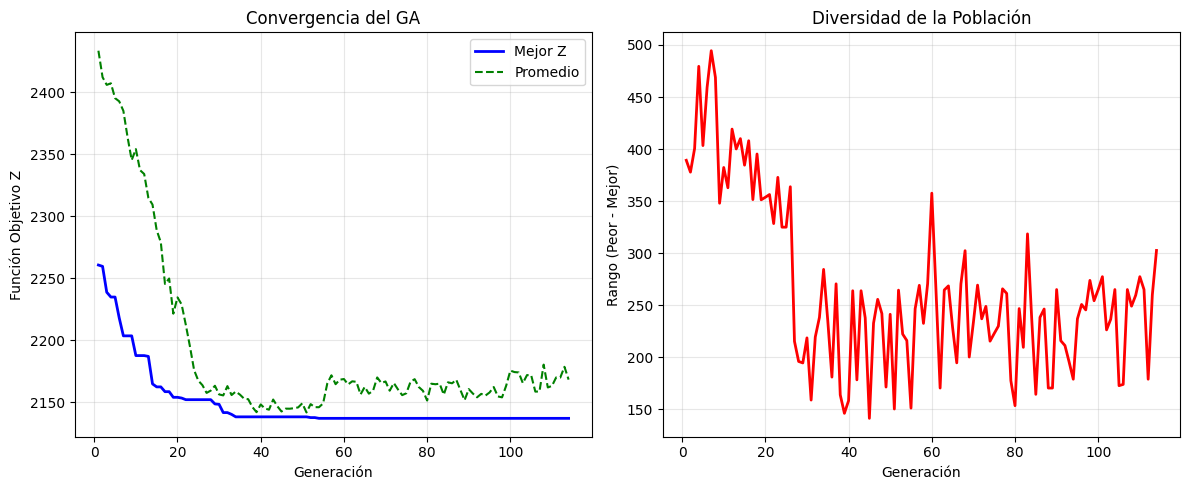


Mejora total: 123.50 (5.5%)


In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gen, history_best, 'b-', label='Mejor Z', linewidth=2)
plt.plot(history_gen, history_avg, 'g--', label='Promedio', linewidth=1.5)
plt.xlabel('Generación')
plt.ylabel('Función Objetivo Z')
plt.title('Convergencia del GA')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_gen, [worst - best for best, worst in zip(history_best, history_worst)], 'r-', linewidth=2)
plt.xlabel('Generación')
plt.ylabel('Rango (Peor - Mejor)')
plt.title('Diversidad de la Población')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMejora total: {history_best[0] - history_best[-1]:.2f} ({100*(history_best[0]-history_best[-1])/history_best[0]:.1f}%)")

---

## Paso 8: Ver la Solución Final

In [41]:
# Evaluar la mejor solución encontrada
resultado_final = evaluate_individual(best, inst)

print("\n" + "="*60)
print("SOLUCIÓN FINAL ENCONTRADA POR EL GA")
print("="*60)

print(f"\n💰 COSTOS:")
print(f"  Z (Objetivo Total):      {resultado_final['Z']:.2f}")
print(f"  Costo (contratos):       {resultado_final['cost']:.2f}")
print(f"  Penalizaciones:          {resultado_final['penalty']:.2f}")
print(f"  Espera total (horas):    {resultado_final['total_wait']:.2f}")

print(f"\n🚚 RUTAS OPTIMIZADAS:")
for i, route in enumerate(resultado_final['routes']):
    if route:
        hs = resultado_final['scheduled'].get(i, 'N/A')
        det = resultado_final['details'].get(i, {})
        print(f"\n  Camión {i+1}:")
        print(f"    Ruta: 0 -> {' -> '.join(map(str, route))} -> 0")
        print(f"    Hora Salida: {hs}")
        if det.get('HRegreso'):
            print(f"    Hora Regreso: {det['HRegreso']:.2f}")
            print(f"    Tiempo Total: {det['TT']:.2f} horas")
    else:
        print(f"\n  Camión {i+1}: NO UTILIZADO")


SOLUCIÓN FINAL ENCONTRADA POR EL GA

💰 COSTOS:
  Z (Objetivo Total):      2137.16
  Costo (contratos):       1341.41
  Penalizaciones:          795.75
  Espera total (horas):    0.00

🚚 RUTAS OPTIMIZADAS:

  Camión 1:
    Ruta: 0 -> 12 -> 5 -> 3 -> 14 -> 0
    Hora Salida: 0.498
    Hora Regreso: 2.79
    Tiempo Total: 2.29 horas

  Camión 2:
    Ruta: 0 -> 13 -> 1 -> 10 -> 2 -> 0
    Hora Salida: 0.0
    Hora Regreso: 5.27
    Tiempo Total: 5.27 horas

  Camión 3:
    Ruta: 0 -> 8 -> 11 -> 9 -> 0
    Hora Salida: 0.498
    Hora Regreso: 2.31
    Tiempo Total: 1.81 horas

  Camión 4:
    Ruta: 0 -> 7 -> 6 -> 4 -> 0
    Hora Salida: 0.0
    Hora Regreso: 3.35
    Tiempo Total: 3.35 horas


---

## Paso 9: Resumen y Conclusiones

In [42]:
print("\n" + "="*60)
print("RESUMEN DEL PROCESO")
print("="*60)

print(f"""
✓ Algoritmo ejecutado con éxito

📊 ESTADÍSTICAS:
  - Generaciones completadas: {len(history_gen)}
  - Mejora inicial: {history_best[0]:.2f} -> {history_best[-1]:.2f}
  - Mejora porcentual: {100*(history_best[0]-history_best[-1])/history_best[0]:.1f}%
  - Z Final: {resultado_final['Z']:.2f}

🎯 SIGUIENTE PASO:
  1. Ajusta los parámetros (tamaño población, generaciones, etc.)
  2. Prueba con otro archivo .dat
  3. Compara resultados entre diferentes configuraciones

💡 TIPS:
  - Mayor población = exploración más lenta pero más profunda
  - Más generaciones = mejor solución pero más tiempo
  - Aumentar local_fraction busca mejorar más las rutas
""")


RESUMEN DEL PROCESO

✓ Algoritmo ejecutado con éxito

📊 ESTADÍSTICAS:
  - Generaciones completadas: 114
  - Mejora inicial: 2260.66 -> 2137.16
  - Mejora porcentual: 5.5%
  - Z Final: 2137.16

🎯 SIGUIENTE PASO:
  1. Ajusta los parámetros (tamaño población, generaciones, etc.)
  2. Prueba con otro archivo .dat
  3. Compara resultados entre diferentes configuraciones

💡 TIPS:
  - Mayor población = exploración más lenta pero más profunda
  - Más generaciones = mejor solución pero más tiempo
  - Aumentar local_fraction busca mejorar más las rutas



---

## (Opcional) Ejecutar el GA Completo desde CLI

Si prefieres no usar este notebook, puedes ejecutar el GA desde línea de comandos:

In [43]:
print("""
╔════════════════════════════════════════════════════════════════╗
║  EJECUTAR DESDE TERMINAL (SIN NOTEBOOK)                        ║
╚════════════════════════════════════════════════════════════════╝

Comando básico (con valores por defecto):
  python scripts/run_ga_spec.py --dat instances/sebas.dat

Con parámetros personalizados:
  python scripts/run_ga_spec.py --dat instances/sebas.dat \\
    --popsize 100 --gens 500 --seed 42 --out resultados_ga

Opciones disponibles:
  --dat FILE              Ruta al archivo .dat (requerido)
  --out DIR               Directorio de salida (default: results_spec)
  --seed N                Semilla para reproducibilidad (default: 42)
  --popsize N             Tamaño de población (default: 100)
  --gens N                Número de generaciones (default: 500)
  --local-fraction N      Fracción de rutas con búsqueda local (default: 0.3)
  --local-last-only       Aplicar búsqueda local solo en última generación

Ejemplo completo:
  python scripts/run_ga_spec.py --dat instances/sebas.dat \\
    --popsize 50 --gens 100 --seed 123 --out mi_resultado
""")


╔════════════════════════════════════════════════════════════════╗
║  EJECUTAR DESDE TERMINAL (SIN NOTEBOOK)                        ║
╚════════════════════════════════════════════════════════════════╝

Comando básico (con valores por defecto):
  python scripts/run_ga_spec.py --dat instances/sebas.dat

Con parámetros personalizados:
  python scripts/run_ga_spec.py --dat instances/sebas.dat \
    --popsize 100 --gens 500 --seed 42 --out resultados_ga

Opciones disponibles:
  --dat FILE              Ruta al archivo .dat (requerido)
  --out DIR               Directorio de salida (default: results_spec)
  --seed N                Semilla para reproducibilidad (default: 42)
  --popsize N             Tamaño de población (default: 100)
  --gens N                Número de generaciones (default: 500)
  --local-fraction N      Fracción de rutas con búsqueda local (default: 0.3)
  --local-last-only       Aplicar búsqueda local solo en última generación

Ejemplo completo:
  python scripts/run_ga_sp